In [1298]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t
from scipy.stats import f
import matplotlib.ticker as ticker
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

## Preparation

#### Drivers

In [1299]:
drivers = 'formula1_2023_drivers.csv'
df_drivers = pd.read_csv(drivers)

In [1300]:
del df_drivers['Highest Race Finish']

In [1301]:
del df_drivers['Highest Grid Position']

In [1302]:
del df_drivers['Place of Birth']

In [1303]:
df_drivers.head()

,Season,Driver,Number,Team,Country,Podiums,Points,Grands Prix Entered,World Championships,Age,Years of experience,Number of first places in season,Total points in season
0,2023,Max Verstappen,1,Red Bull Racing,Netherlands,98,2586.5,185,3,26,8,19,516
1,2023,Sergio Perez,11,Red Bull Racing,Mexico,35,1486.0,258,0,34,12,2,260
2,2023,Lewis Hamilton,44,Mercedes,United Kingdom,197,4639.5,332,7,39,16,0,217
3,2023,Fernando Alonso,14,Aston Martin,Spain,106,2267.0,380,2,42,22,0,206
4,2023,Charles Leclerc,16,Ferrari,Monaco,30,1074.0,125,0,26,5,0,206


#### Tracks

In [1304]:
tracks = 'formula1_2023_tracks.csv'
df_tracks = pd.read_csv(tracks)

In [1305]:
del df_tracks['Lap Record']

In [1306]:
times = ['1:33:56.736', '1:21:14.894', '2:32:28.371', '1:32:42.436', '1:27:38.241', '1:48:51.980', '1:27:57.940', '1:33:58.348', '1:25:33.607', '1:25:16.938', '1:38:08.634', '1:22:30.450', '2:24:04.411', '1:13:41.143', '1:46:37.418', '1:30:58.421', '1:27:39.168', '1:35:21.362', '2:02:30.814', '1:56:48.894', '1:29:08.289', '1:27:02.624']

# Function to convert time string (h:mm:ss) to minutes
def time_to_minutes(time_str):
    parts = time_str.split(':')  # Split the time string by ':'
    hours = int(parts[0])         # Extract hours part and convert to integer
    minutes = int(parts[1])       # Extract minutes part and convert to integer
    total_minutes = hours * 60 + minutes  # Convert hours to minutes and add minutes
    return total_minutes

# Convert each time in the list to total minutes
times_in_minutes = [time_to_minutes(t) for t in times]

# Print the transformed list of race times in minutes
df_tracks['Time of race (min)'] = times_in_minutes

In [1307]:
df_tracks.head()

,Round,Country,City,Circuit Name,Date,First Grand Prix,Number of Laps,Circuit Length(km),Race Distance(km),Average speed,Record Owner,Record Year,Turns,DRS Zones,Time of race (min)
0,1,Bahrain,Sakhir,Bahrain International Circuit,05/03/2023,2004,57,5.412,308.238,193.25,Pedro de la Rosa,2005,15,3,93
1,2,Saudi Arabia,Jeddah,Jeddah Corniche Circuit,19/03/2023,2021,50,6.174,308.450,224.83,Lewis Hamilton,2021,27,3,81
2,3,Australia,Melbourne,Melbourne Grand Prix Circuit,02/04/2023,1996,58,5.278,306.124,136.10,Sergio Perez,2023,14,4,152
3,4,Azerbaijan,Baku,Baku City Circuit,30/04/2023,2016,51,6.003,306.049,195.79,Charles Leclerc,2019,20,2,92
4,5,United States,Miami,Miami International Autodrome,07/05/2023,2022,57,5.412,308.326,208.56,Max Verstappen,2023,19,3,87


#### Race Results

In [1308]:
results = 'formula1_2023_raceResults.csv'
df_results = pd.read_csv(results)

In [1309]:
df_results['Fastest Lap'] = df_results['Fastest Lap'].replace({'Yes': 1, 'No': 0})

In [1310]:
df_results.head()

,Season,Track,Position,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,Fastest Lap
0,2023,Bahrain,1,1,Max Verstappen,Red Bull Racing Honda RBPT,1,57,1:33:56.736,25,0
1,2023,Bahrain,2,11,Sergio Perez,Red Bull Racing Honda RBPT,2,57,+11.987,18,0
2,2023,Bahrain,3,14,Fernando Alonso,Aston Martin Aramco Mercedes,5,57,+38.637,15,0
3,2023,Bahrain,4,55,Carlos Sainz,Ferrari,4,57,+48.052,12,0
4,2023,Bahrain,5,44,Lewis Hamilton,Mercedes,7,57,+50.977,10,0


# EDA

## Season

#### Average age of drivers

In [1311]:
driver = df_drivers['Driver']
driver

0       Max Verstappen
1         Sergio Perez
2       Lewis Hamilton
3      Fernando Alonso
4      Charles Leclerc
5         Lando Norris
6         Carlos Sainz
7       George Russell
8        Oscar Piastri
9         Lance Stroll
10        Pierre Gasly
11        Esteban Ocon
12     Alexander Albon
13        Yuki Tsunoda
14     Valtteri Bottas
15     Nico Hulkenberg
16    Daniel Ricciardo
17         Guanyu Zhou
18     Kevin Magnussen
19         Liam Lawson
20      Logan Sargeant
21       Nyck De Vries
Name: Driver, dtype: object

In [1312]:
average_age = df_drivers['Age'].mean()
average_age

28.772727272727273

#### Nationality

In [1313]:
country_counts = df_drivers['Country'].value_counts()
country_counts

United Kingdom    3
Netherlands       2
Australia         2
France            2
Monaco            1
Sapin             1
Spain             1
Canada            1
Mexico            1
Thailand          1
Japan             1
Finland           1
Germany           1
China             1
Denmark           1
New Zealand       1
United States     1
Name: Country, dtype: int64

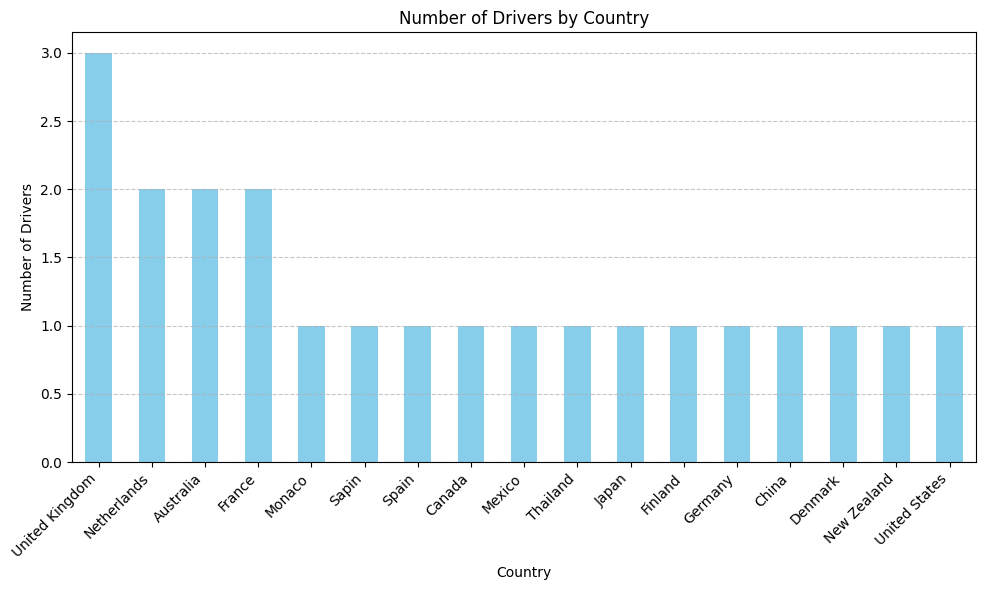

In [1314]:
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)
country_counts.plot(kind='bar', color='skyblue')  # Create a bar plot
plt.title('Number of Drivers by Country')  # Set the title of the plot
plt.xlabel('Country')  # Set the label for the x-axis
plt.ylabel('Number of Drivers')  # Set the label for the y-axis
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()  # Display the plot

#### Number of first places

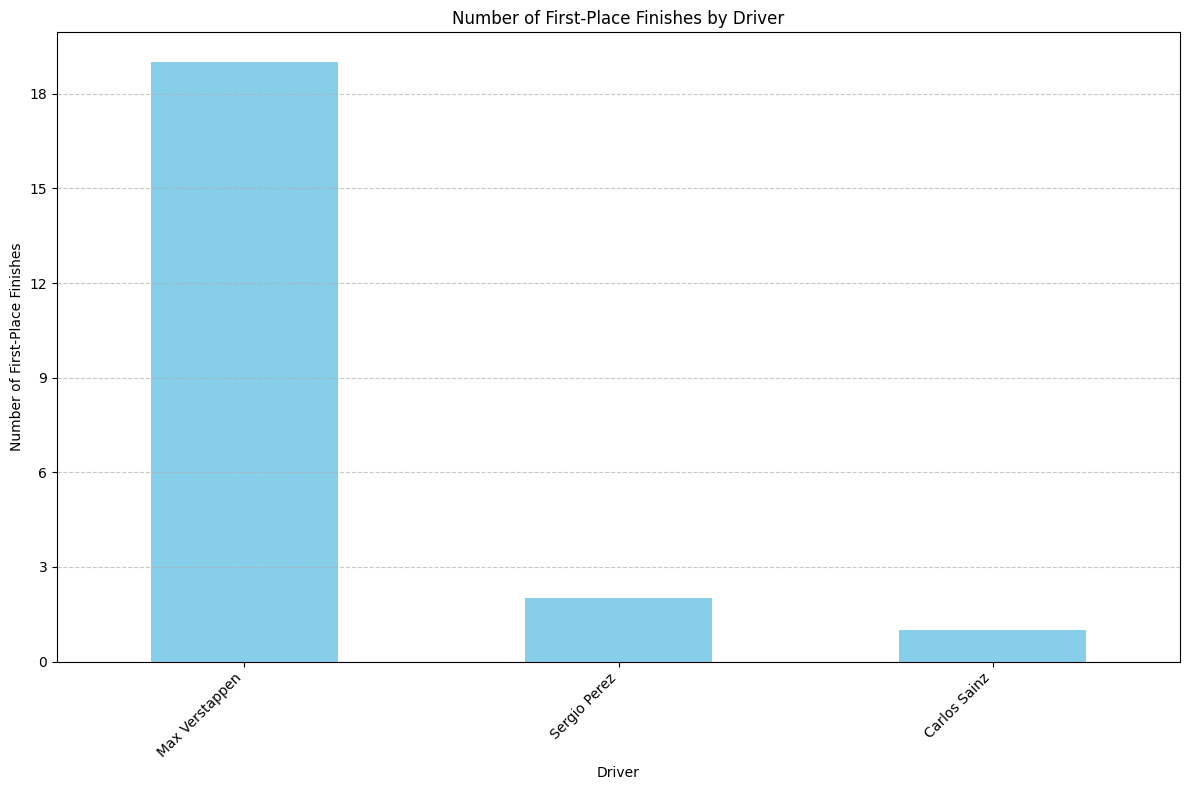

In [1315]:
df_results['Position'] = df_results['Position'].str.extract('(\d+)').astype(float)

df_position_1 = df_results[df_results['Position'] == 1]

driver_counts_1 = df_position_1['Driver'].value_counts()

plt.figure(figsize=(12, 8))  # Set the figure size (width, height)
driver_counts_1.plot(kind='bar', color='skyblue')  # Create a bar plot
plt.title('Number of First-Place Finishes by Driver')  # Set the title of the plot
plt.xlabel('Driver')  # Set the label for the x-axis
plt.ylabel('Number of First-Place Finishes')  # Set the label for the y-axis
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for y-axis
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3))
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()  # Display the plot

In [1316]:
# Convert 'Position' column to numeric (extract the first digit)
df_results['Position'] = df_results['Position'].astype(str).str.extract('(\d+)').astype(float)

# Filter to include only rows where Position is 1 (first-place finishes)
df_position_1 = df_results[df_results['Position'] == 1]

# Count the number of first-place finishes for each driver
driver_counts_1 = df_position_1['Driver'].value_counts()

# Create a DataFrame to store results for all drivers with first-place finishes
results_table = pd.DataFrame({
    'Driver': driver_counts_1.index,
    'Number of First Positions': driver_counts_1.values
})

# Initialize an empty list to store the teams corresponding to each driver
teams = []

# Iterate over each driver in the results table to fetch their respective team
for driver in results_table['Driver']:
    # Find the first team associated with the driver in df_position_1 (assuming unique team per driver per race)
    team = df_position_1[df_position_1['Driver'] == driver]['Team'].iloc[0]
    teams.append(team)

# Add the 'Team' column to the results table
results_table['Team'] = teams

# Display the results table
pd.DataFrame(results_table)

,Driver,Number of First Positions,Team
0,Max Verstappen,19,Red Bull Racing Honda RBPT
1,Sergio Perez,2,Red Bull Racing Honda RBPT
2,Carlos Sainz,1,Ferrari


#### Total points for each driver for each race

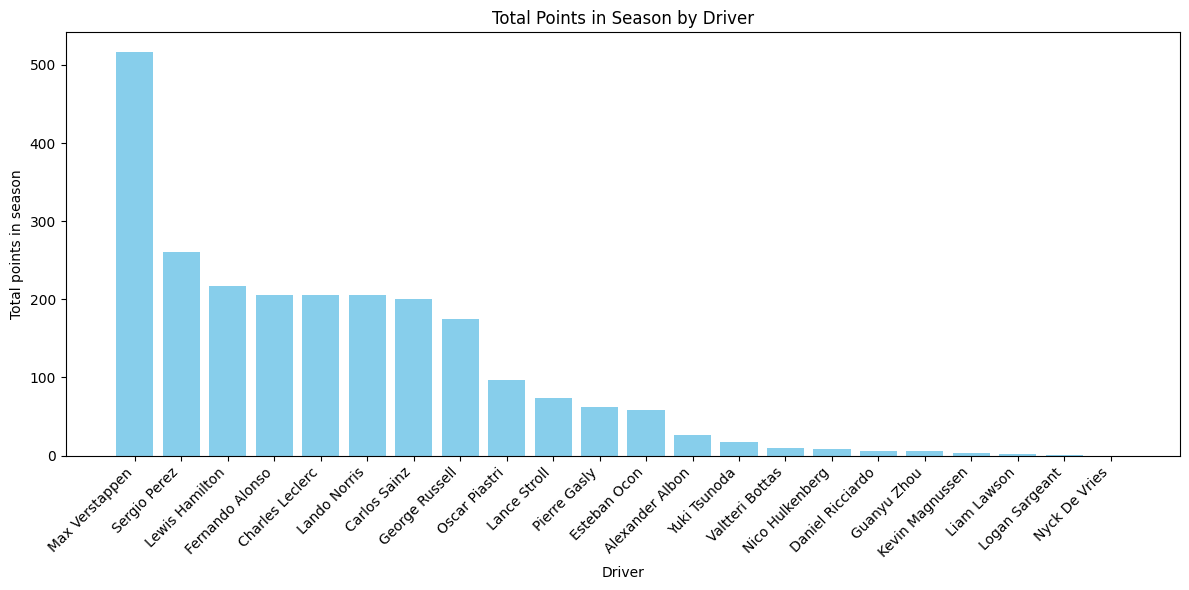

In [1317]:
pilot = df_drivers['Driver']
points = df_drivers['Total points in season']

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.bar(pilot, points, color='skyblue')
plt.xlabel('Driver')
plt.ylabel('Total points in season')
plt.title('Total Points in Season by Driver')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()


#### Constructors

In [1318]:
team_counts = df_drivers['Team'].value_counts()
team_counts

AlphaTauri         4
Red Bull Racing    2
Mercedes           2
Aston Martin       2
Ferrari            2
McLaren            2
Alpine             2
Williams           2
Alfa Romeo         2
Haas F1 Team       2
Name: Team, dtype: int64

#### Number of points for each constructor for each race

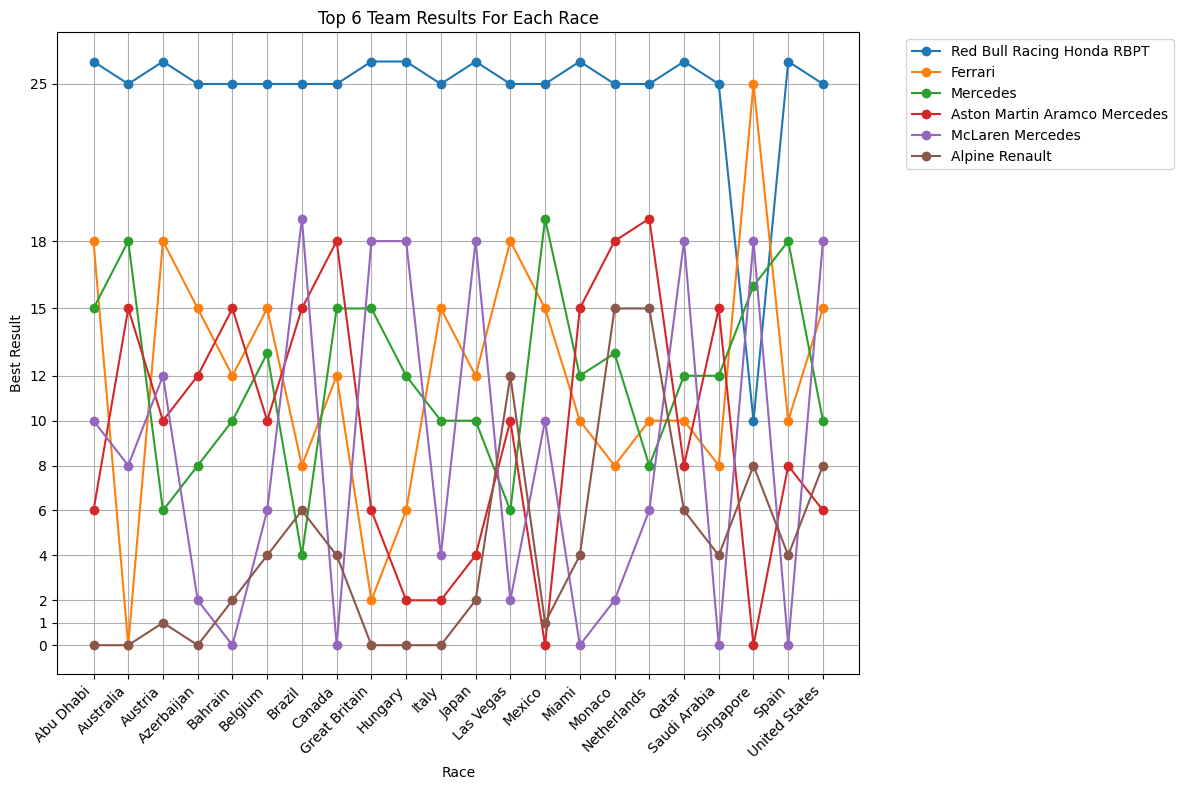

In [1319]:
team_data = df_results.groupby(['Team', 'Track'])['Points'].max().reset_index()

team_points = team_data.groupby('Team')['Points'].sum().reset_index()
team_points = team_points.sort_values('Points', ascending=False)
top_teams = team_points.head(6)['Team']

plt.figure(figsize=(12, 8))

custom_y_values = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1, 0]

# Iterate over top 6 teams to plot each team's best result on each track
for i, team in enumerate(top_teams):
    team_data = df_results[df_results['Team'] == team]
    team_best_results = team_data.groupby('Track')['Points'].max()
    plt.plot(team_best_results.index, team_best_results.values, label=team, marker='o')

# Add labels and title
plt.xlabel('Race')
plt.ylabel('Best Result')
plt.title('Top 6 Team Results For Each Race')

# Set custom y-axis ticks and labels
plt.yticks(custom_y_values, custom_y_values)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

# Show the plot
plt.tight_layout()
plt.show()




#### Average speed of drivers for each race

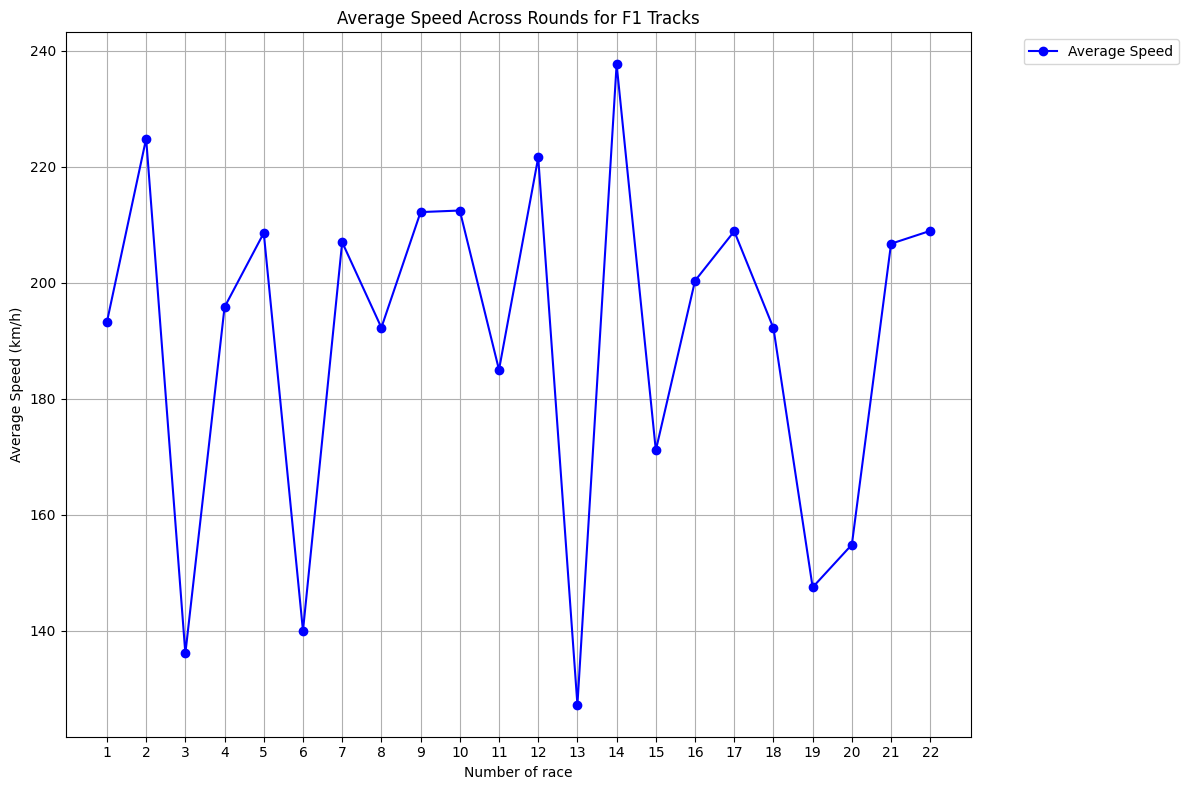

In [1320]:
# Plotting the graph for average speed across rounds (number of rounds)
plt.figure(figsize=(12, 8))

# Extracting data for plotting
round_numbers = df_tracks['Round']
average_speeds = df_tracks['Average speed']

# Plotting the line graph
plt.plot(round_numbers, average_speeds, marker='o', linestyle='-', color='b', label='Average Speed')

# Add labels and title
plt.xlabel('Number of race')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed Across Rounds for F1 Tracks')
plt.xticks(round_numbers)  # Set x-axis ticks to round numbers
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 

# Show the plot
plt.tight_layout()
plt.show()


#### Time for each race

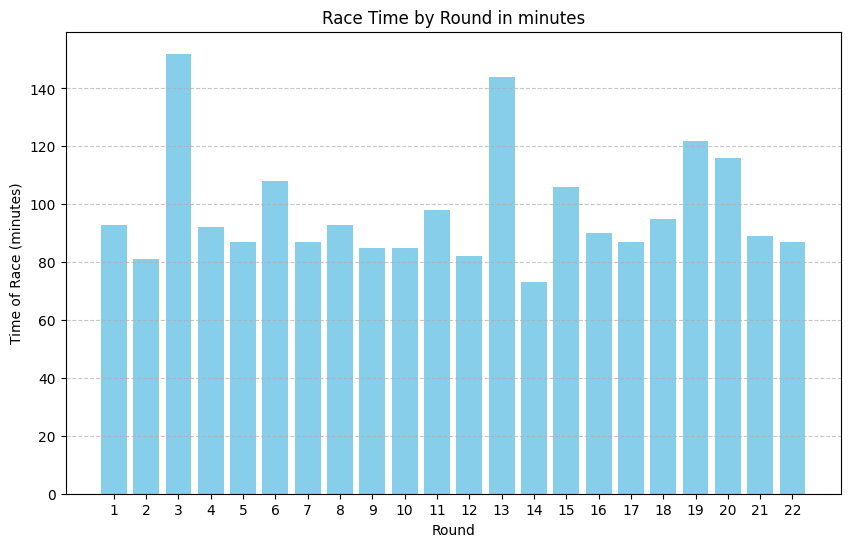

In [1321]:
rounds = df_tracks['Round']
race_times = df_tracks['Time of race (min)']

plt.figure(figsize=(10, 6))
plt.bar(rounds, race_times, color='skyblue')
plt.xlabel('Round')
plt.ylabel('Time of Race (minutes)')
plt.title('Race Time by Round in minutes')
plt.xticks(rounds)  # Set x-axis ticks to match the rounds
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Displaying the plot
plt.show()

#### Counties in a season

In [1322]:
country_counts = df_tracks['Country'].value_counts()
country_counts

United States    3
Bahrain          1
Belgium          1
Brazil           1
Mexico           1
Qatar            1
Japan            1
Singapore        1
Italy            1
Netherlands      1
Hungary          1
Saudi Arabia     1
Great Britain    1
Austria          1
Canada           1
Spain            1
Monaco           1
Azerbaijan       1
Australia        1
Abu Dhabi        1
Name: Country, dtype: int64

### Starting grid

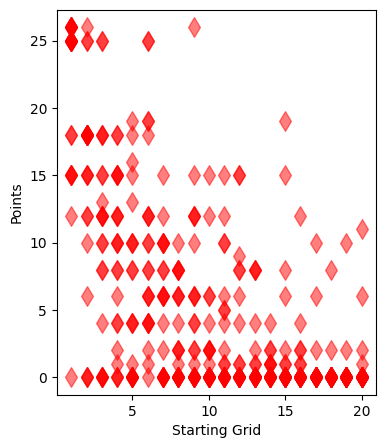

In [1323]:
plt.figure(figsize=(14,5))
plt.subplot(1, 3, 1)
plt.scatter(df_results['Starting Grid'], df_results['Points'], marker='d', color='red', s=100, alpha=0.5)
plt.xlabel('Starting Grid')
plt.ylabel('Points')
plt.show()


In [1324]:
points = df_results['Points'].values
starting = df_results['Starting Grid'].values
print("Starting Grid-Points Correlation: {:.4}".format(np.corrcoef(starting, points)[0,1]))

Starting Grid-Points Correlation: -0.6306


## Maxim

In [1325]:
driver_max = 'max.csv'
df_max = pd.read_csv(driver_max)

#### Average speed for each race

In [1326]:
average_speed = df_max['Speed'].mean()
average_speed

191.71213636363635

#### Points for each race

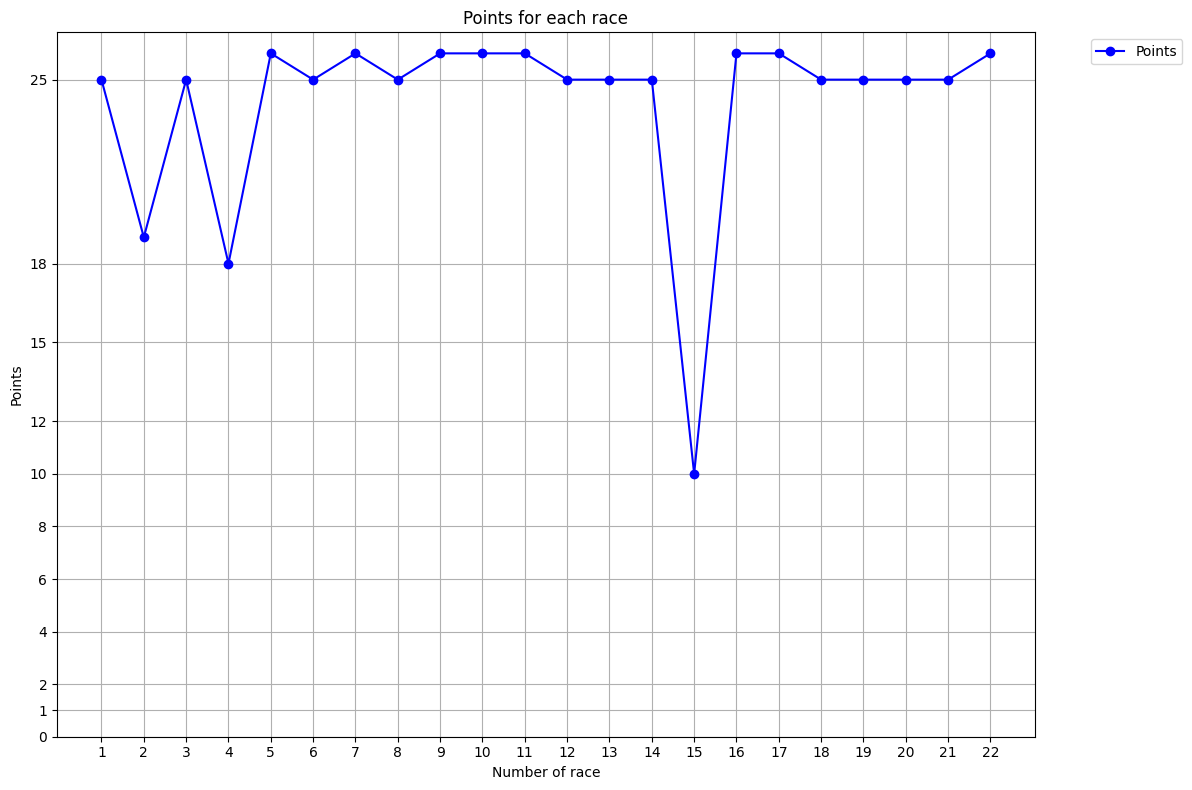

In [1327]:
# Plotting the graph for average speed across rounds (number of rounds)
plt.figure(figsize=(12, 8))

custom_y_values = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1, 0]

# Extracting data for plotting
round_numbers = df_max['№ Race']
point = df_max['Points']

# Plotting the line graph
plt.plot(round_numbers, point, marker='o', linestyle='-', color='b', label='Points')

# Add labels and title
plt.xlabel('Number of race')
plt.ylabel('Points')
plt.title('Points for each race')
plt.yticks(custom_y_values, custom_y_values)
plt.xticks(round_numbers)  # Set x-axis ticks to round numbers
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 

# Show the plot
plt.tight_layout()
plt.show()

#### Fastest Lap for each race

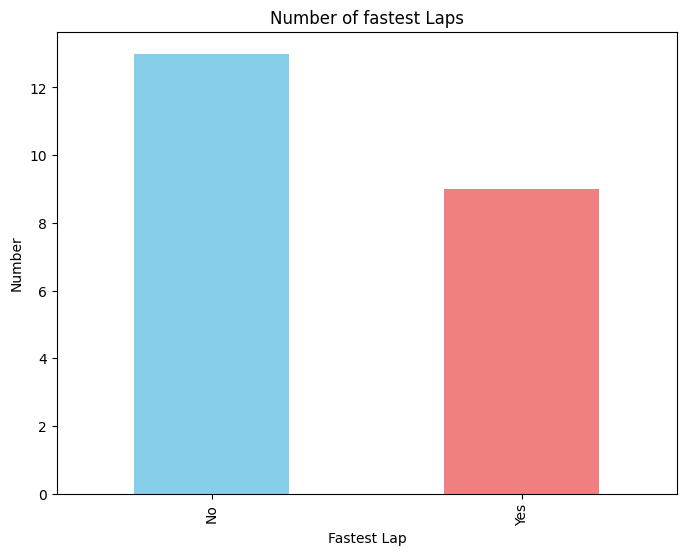

In [1328]:
fastest_lap_counts = df_max['Fastest Lap'].value_counts()

# Plotting the histogram
plt.figure(figsize=(8, 6))

# Plot the histogram
fastest_lap_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])

# Add title and labels
plt.title('Number of fastest Laps')
plt.xlabel('Fastest Lap')
plt.ylabel('Number')

# Show the plot
plt.show()

#### Number of wins

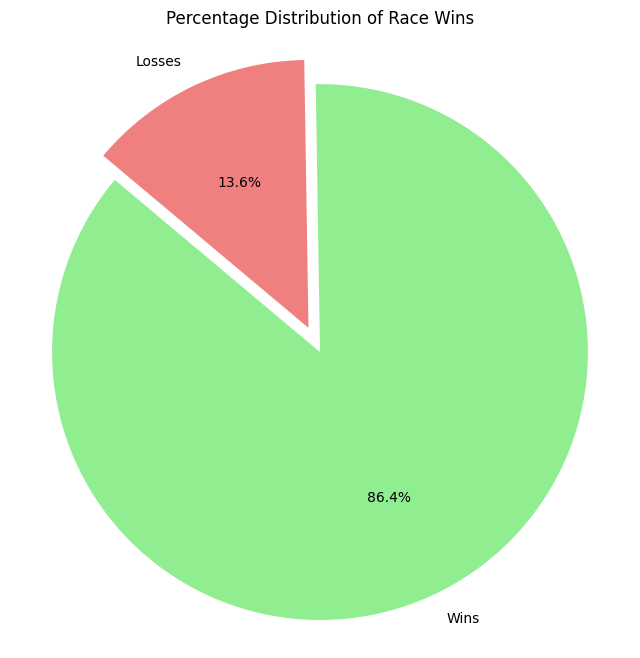

In [1329]:
position_counts = df_max['Position'].value_counts()

# Get the count of wins (position 1)
wins_count = position_counts.get(1, 0)  # Get count of '1', default to 0 if not present

# Calculate count of other positions
other_positions_count = position_counts.sum() - wins_count

# Calculate percentages
total_positions = wins_count + other_positions_count
wins_percentage = (wins_count / total_positions) * 100
other_positions_percentage = (other_positions_count / total_positions) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 8))

# Define labels and sizes for the pie chart
labels = ['Wins', 'Losses']
sizes = [wins_percentage, other_positions_percentage]

# Define colors for the pie chart
colors = ['lightgreen', 'lightcoral']

# Explode the Position 1 slice for emphasis
explode = (0.1, 0)

# Plotting the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)

# Add title
plt.title('Percentage Distribution of Race Wins')

# Show the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



## Race 15

In [1330]:
race = 'race15.csv'
df_race = pd.read_csv(race)
df_race.head()

,Season,Track,Position,No,Driver,Team,Starting Grid,Laps,Time,Speed,Points,Fastest Lap,Age,PS
0,2023,Singapore,1,55,Carlos Sainz,Ferrari,1,62,106.62,172.274,25,No,29,1
1,2023,Singapore,2,4,Lando Norris,McLaren Mercedes,4,62,106.63,172.253,18,No,24,1
2,2023,Singapore,3,44,Lewis Hamilton,Mercedes,5,62,106.64,172.240,16,Yes,39,2
3,2023,Singapore,4,16,Charles Leclerc,Ferrari,3,62,106.97,171.706,12,No,26,1
4,2023,Singapore,5,1,Max Verstappen,Red Bull Racing Honda RBPT,11,62,106.98,171.699,10,No,26,1


#### Number of pitstops for each driver

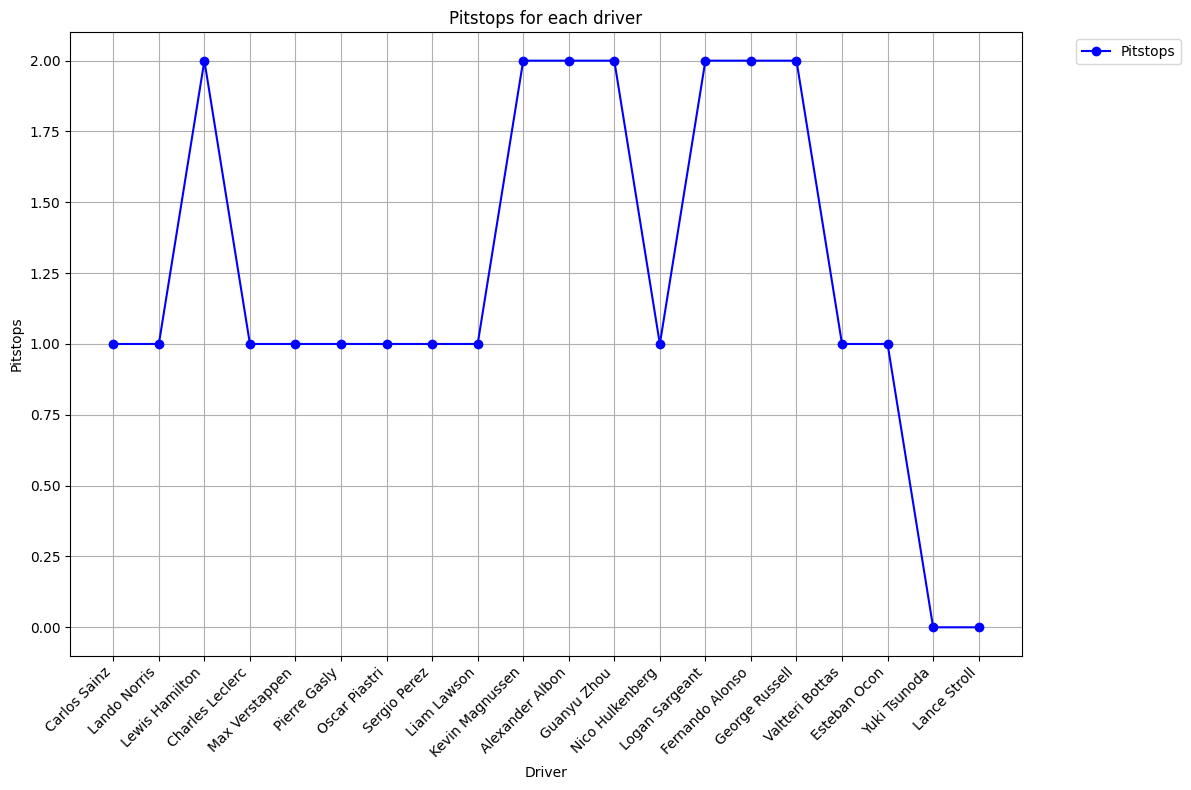

In [1331]:
# Plotting the graph for average speed across rounds (number of rounds)
plt.figure(figsize=(12, 8))

# Extracting data for plotting
driver = df_race['Driver']
pitstops = df_race['PS']

# Plotting the line graph
plt.plot(driver, pitstops, marker='o', linestyle='-', color='b', label='Pitstops')

# Add labels and title
plt.xlabel('Driver')
plt.ylabel('Pitstops')
plt.title('Pitstops for each driver')
plt.xticks(driver)
plt.xticks(rotation=45, ha='right') 
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 

# Show the plot
plt.tight_layout()
plt.show()

#### Positions for each driver

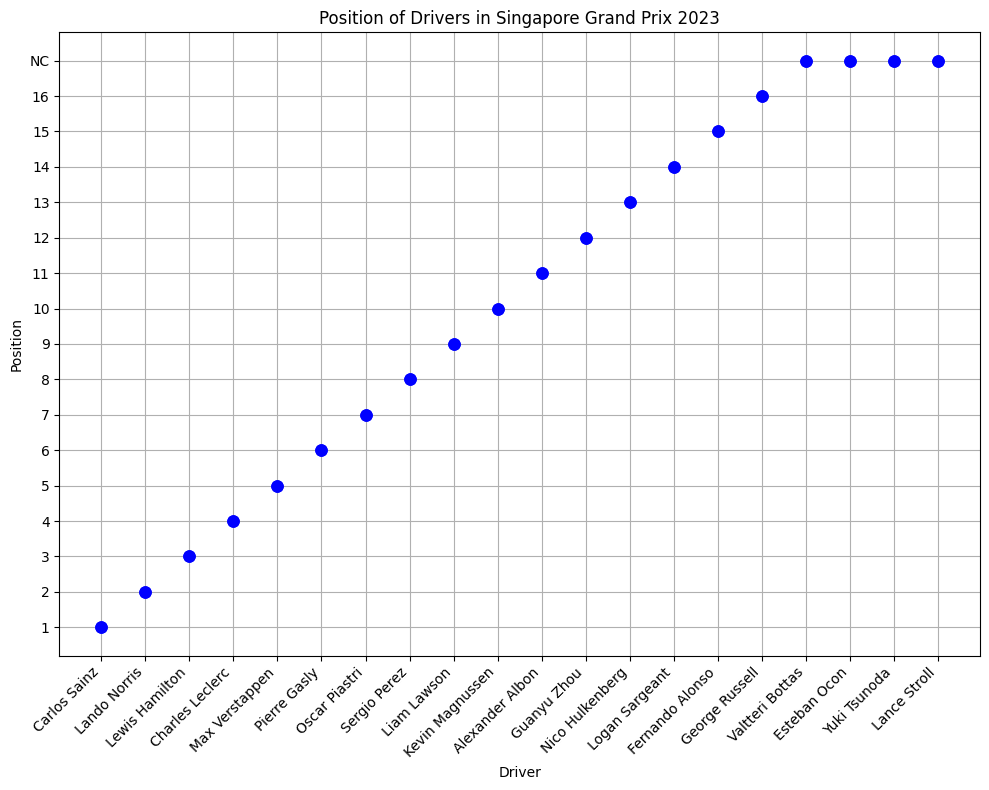

In [1332]:
# Plotting the graph
plt.figure(figsize=(10, 8))

# Iterate over each driver to plot their position
for idx, row in df_race.iterrows():
    driver = row['Driver']
    position = row['Position']
    
    # Plot a line for the driver's position
    plt.plot([driver, driver], [position, position], color='blue', linewidth=2, marker='o', markersize=8)

# Add labels and title
plt.xlabel('Driver')
plt.ylabel('Position')
plt.title('Position of Drivers in Singapore Grand Prix 2023')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show grid
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### Creating dummy variables

In [1333]:
rows_to_exclude = df_results['Position'] == 'NC'
df_results = df_results[~rows_to_exclude]

In [1334]:
df_results['Red Bull'] = np.where(df_results['Team'].str.contains('Red Bull', case=False), 1, 0)
df_results['Ferrari'] = np.where(df_results['Team'].str.contains('Ferrari', case=False), 1, 0)


In [1335]:
rows_to_exclude = df_race['Position'] == 'NC'
df_race = df_race[~rows_to_exclude]

In [1336]:
rows_to_exclude = df_race['Time'] == 'DNF'
df_race = df_race[~rows_to_exclude]

In [1337]:
df_race['Fastest Lap'] = df_race['Fastest Lap'].replace({'Yes': 1, 'No': 0})
df_race['Red Bull'] = np.where(df_race['Team'].str.contains('Red Bull', case=False), 1, 0)
df_race['Ferrari'] = np.where(df_race['Team'].str.contains('Ferrari', case=False), 1, 0)

In [1338]:
df_race.head()

,Season,Track,Position,No,Driver,Team,Starting Grid,Laps,Time,Speed,Points,Fastest Lap,Age,PS,Red Bull,Ferrari
0,2023,Singapore,1,55,Carlos Sainz,Ferrari,1,62,106.62,172.274,25,0,29,1,0,1
1,2023,Singapore,2,4,Lando Norris,McLaren Mercedes,4,62,106.63,172.253,18,0,24,1,0,0
2,2023,Singapore,3,44,Lewis Hamilton,Mercedes,5,62,106.64,172.240,16,1,39,2,0,0
3,2023,Singapore,4,16,Charles Leclerc,Ferrari,3,62,106.97,171.706,12,0,26,1,0,1
4,2023,Singapore,5,1,Max Verstappen,Red Bull Racing Honda RBPT,11,62,106.98,171.699,10,0,26,1,1,0


In [1339]:
df_max['Fastest Lap'] = df_max['Fastest Lap'].replace({'Yes': 1, 'No': 0})

In [1340]:
df_max.head()

,№ Race,Track,Position,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,Fastest Lap,Speed,Length,Distance,Turns,DRZ,PS,Wet,Track heat
0,1,Bahrain,1,1,Max Verstappen,Red Bull Racing Honda RBPT,1,57,93.94,25,0,196.861,5.412,308.238,15,3,2,0,31
1,2,Saudi Arabia,2,1,Max Verstappen,Red Bull Racing Honda RBPT,15,50,81.39,19,1,227.533,6.174,308.450,27,3,1,0,32
2,3,Australia,1,1,Max Verstappen,Red Bull Racing Honda RBPT,1,58,152.47,25,0,120.332,5.278,306.124,14,4,3,0,35
3,4,Azerbaijan,2,1,Max Verstappen,Red Bull Racing Honda RBPT,2,51,92.42,18,0,197.998,6.003,306.049,20,2,1,0,42
4,5,Miami,1,1,Max Verstappen,Red Bull Racing Honda RBPT,9,57,87.63,26,1,211.092,5.412,308.326,19,3,1,0,44


### Analysing Max

In [1341]:
X = df_max[['Starting Grid', 'Laps', 'Length', 'Distance', 'Turns', 'DRZ', 'Fastest Lap', 'Speed', 'Wet', 'Track heat', 'PS']]

y = df_max['Points']

X = sm.add_constant(X)
mod = sm.OLS(y, X)

results = mod.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     1.247
Date:                Fri, 03 May 2024   Prob (F-statistic):              0.368
Time:                        10:17:23   Log-Likelihood:                -50.451
No. Observations:                  22   AIC:                             124.9
Df Residuals:                      10   BIC:                             138.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -97.2236     97.802     -0.994

In [1342]:
variance = pd.DataFrame()
variance["Variables"] = X.columns
variance["Variance inflation"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(variance)

        Variables  Variance inflation
0           const        16644.964155
1   Starting Grid            5.038039
2            Laps           85.408092
3          Length           97.617820
4        Distance            5.349476
5           Turns            6.325410
6             DRZ            3.434110
7     Fastest Lap            1.903575
8           Speed            7.170505
9             Wet            4.997593
10     Track heat            2.051061
11             PS            6.020208


In [1343]:
X = df_max[['Starting Grid','Laps', 'DRZ', 'Fastest Lap', 'Wet', 'Track heat', 'PS']]

y = df_max['Points']

X = sm.add_constant(X)
mod = sm.OLS(y, X)

results = mod.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     1.918
Date:                Fri, 03 May 2024   Prob (F-statistic):              0.142
Time:                        10:17:23   Log-Likelihood:                -52.553
No. Observations:                  22   AIC:                             121.1
Df Residuals:                      14   BIC:                             129.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            27.2247      5.893      4.620

In [1344]:
variance = pd.DataFrame()
variance["Variables"] = X.columns
variance["Variance inflation"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(variance)

       Variables  Variance inflation
0          const           69.878832
1  Starting Grid            1.613118
2           Laps            2.649963
3            DRZ            1.972864
4    Fastest Lap            1.267235
5            Wet            2.340602
6     Track heat            1.511823
7             PS            1.544775


### Hypothesis

#### Starting grid

In [1345]:
coef_educ = results.params['Starting Grid']
se_educ = results.bse['Starting Grid']

# Calculate t-statistic
t_stat = coef_educ / se_educ

# Calculate degrees of freedom
df = len(df_max) - len(results.params) - 1

# Calculate p-value (two-tailed test)
p_value = 2 * (1 - t.cdf(abs(t_stat), df))

# Specify significance level
alpha = 0.05

# Output the results
print(f"P-value: {p_value:.4f}")

# Perform hypothesis test
if p_value < alpha:
    print("Reject the null hypothesis (Starting grid has a significant effect on number of points).")
else:
    print("Fail to reject the null hypothesis (Starting grid not have a significant effect on number of points).")

P-value: 0.0108
Reject the null hypothesis (Starting grid has a significant effect on number of points).


### Analysing Race 15

In [1346]:
df_race.head()

,Season,Track,Position,No,Driver,Team,Starting Grid,Laps,Time,Speed,Points,Fastest Lap,Age,PS,Red Bull,Ferrari
0,2023,Singapore,1,55,Carlos Sainz,Ferrari,1,62,106.62,172.274,25,0,29,1,0,1
1,2023,Singapore,2,4,Lando Norris,McLaren Mercedes,4,62,106.63,172.253,18,0,24,1,0,0
2,2023,Singapore,3,44,Lewis Hamilton,Mercedes,5,62,106.64,172.240,16,1,39,2,0,0
3,2023,Singapore,4,16,Charles Leclerc,Ferrari,3,62,106.97,171.706,12,0,26,1,0,1
4,2023,Singapore,5,1,Max Verstappen,Red Bull Racing Honda RBPT,11,62,106.98,171.699,10,0,26,1,1,0


In [1347]:
X = df_race[['Starting Grid', 'Laps', 'Fastest Lap', 'Speed', 'PS', 'Age', 'Red Bull', 'Ferrari']]

y = df_race['Points']

X = sm.add_constant(X)
mod = sm.OLS(y, X)

results = mod.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     16.32
Date:                Fri, 03 May 2024   Prob (F-statistic):           0.000767
Time:                        10:17:23   Log-Likelihood:                -30.402
No. Observations:                  15   AIC:                             76.80
Df Residuals:                       7   BIC:                             82.47
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Starting Grid     0.0264      0.258      0.102

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [1348]:
variance = pd.DataFrame()
variance["Variables"] = X.columns
variance["Variance inflation"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(variance)

       Variables  Variance inflation
0  Starting Grid            4.066135
1           Laps       220517.497857
2    Fastest Lap            3.253603
3          Speed            5.347268
4             PS            2.226500
5            Age            3.182572
6       Red Bull            1.577509
7        Ferrari            1.374183


In [1349]:
X = df_race[['Starting Grid', 'Fastest Lap', 'PS', 'Age', 'Red Bull', 'Ferrari']]

y = df_race['Points']

X = sm.add_constant(X)
mod = sm.OLS(y, X)

results = mod.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     3.417
Date:                Fri, 03 May 2024   Prob (F-statistic):             0.0562
Time:                        10:17:23   Log-Likelihood:                -42.263
No. Observations:                  15   AIC:                             98.53
Df Residuals:                       8   BIC:                             103.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            36.5130      9.665      3.778

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [1350]:
variance = pd.DataFrame()
variance["Variables"] = X.columns
variance["Variance inflation"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(variance)

       Variables  Variance inflation
0          const           45.571227
1  Starting Grid            1.860077
2    Fastest Lap            1.540483
3             PS            1.812893
4            Age            1.720079
5       Red Bull            1.405713
6        Ferrari            1.323184


#### Hypothesis starting grid

In [1351]:
coef_educ = results.params['Starting Grid']
se_educ = results.bse['Starting Grid']

# Calculate t-statistic
t_stat = coef_educ / se_educ

# Calculate degrees of freedom
df = len(df_race) - len(results.params) - 1

# Calculate p-value (two-tailed test)
p_value = 2 * (1 - t.cdf(abs(t_stat), df))

# Specify significance level
alpha = 0.05

# Output the results
print(f"P-value: {p_value:.4f}")

# Perform hypothesis test
if p_value < alpha:
    print("Reject the null hypothesis (Starting grid has a significant effect on number of points).")
else:
    print("Fail to reject the null hypothesis (Starting grid not have a significant effect on number of points).")

P-value: 0.0319
Reject the null hypothesis (Strating grid has a significant effect on number of points).


#### Hypothesis joint sagnificance of fastest lap and Red Bull team

In [1352]:
X = df_race[['Starting Grid', 'PS', 'Age', 'Ferrari']]

y = df_race['Points']

X = sm.add_constant(X)
mod_restricted = sm.OLS(y, X)

results_restricted = mod_restricted.fit()

# Calculate sum of squared residuals (SSR) for both models
SSR_r = np.sum(results_restricted.resid**2)
SSR_ur = np.sum(results.resid**2)

# Number of restrictions (number of additional variables in unrestricted model)
q = len(results.params) - len(results_restricted.params)

# Degrees of freedom for the denominator
df_denom = len(df_race) - len(results.params) - 1

# Calculate F-statistic
f_stat = ((SSR_r - SSR_ur) / q) / (SSR_ur / df_denom)

# Calculate p-value using F-distribution
p_value = f.sf(f_stat, q, df_denom)

# Specify significance level
alpha = 0.05

# Output the results
print(f"p-value: {p_value:.4f}")

# Perform hypothesis test
if p_value < alpha:
    print("Reject the null hypothesis (Red Bull and Fastest Lap are jointly significant).")
else:
    print("Fail to reject the null hypothesis (Red Bull and Fastest Lap are not jointly significant).")


p-value: 0.2683
Fail to reject the null hypothesis (Red Bull and Fastest Lap are not jointly significant).


#### Logit model

In [1353]:
df_race['Podium'] = (df_race['Points'] >= 16).astype(int)

In [1354]:
X = df_race[['Fastest Lap', 'PS', 'Age', 'Ferrari']]

y = df_race['Podium']

X = sm.add_constant(X)
model = sm.Logit(y, X)
model = model.fit()

print(model.summary())

         Current function value: 0.289212
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 Podium   No. Observations:                   15
Model:                          Logit   Df Residuals:                       10
Method:                           MLE   Df Model:                            4
Date:                Fri, 03 May 2024   Pseudo R-squ.:                  0.4220
Time:                        10:17:23   Log-Likelihood:                -4.3382
converged:                      False   LL-Null:                       -7.5060
Covariance Type:            nonrobust   LLR p-value:                    0.1754
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          23.3669   2.05e+04      0.001      0.999   -4.02e+04    4.02e+04
Fastest Lap    47.8239   1.13e+05      0.000      1.000   -2.2

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1355]:
test = sm.add_constant(df_race[['Fastest Lap', 'PS', 'Age', 'Ferrari']])
y_pred_prob = model.predict(test)

fp, tp, thresholds = roc_curve(y, y_pred_prob)

idx = np.argmax(tp - fp)
threshold = thresholds[idx]

y_new = (y_pred_prob >= threshold).astype(int)
conf_matrix = confusion_matrix(y, y_new)

tn, fp, fn, tp = conf_matrix.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Confusion Matrix:
[[9 3]
 [0 3]]
Accuracy: 0.8
Sensitivity: 1.0
Specificity: 0.75


### Analysing previous experience

In [1356]:
df_drivers.head()

,Season,Driver,Number,Team,Country,Podiums,Points,Grands Prix Entered,World Championships,Age,Years of experience,Number of first places in season,Total points in season
0,2023,Max Verstappen,1,Red Bull Racing,Netherlands,98,2586.5,185,3,26,8,19,516
1,2023,Sergio Perez,11,Red Bull Racing,Mexico,35,1486.0,258,0,34,12,2,260
2,2023,Lewis Hamilton,44,Mercedes,United Kingdom,197,4639.5,332,7,39,16,0,217
3,2023,Fernando Alonso,14,Aston Martin,Spain,106,2267.0,380,2,42,22,0,206
4,2023,Charles Leclerc,16,Ferrari,Monaco,30,1074.0,125,0,26,5,0,206


In [1357]:
X = df_drivers[['Age', 'Podiums', 'World Championships', 'Years of experience']]

y = df_drivers['Number of first places in season']

X = sm.add_constant(X)
mod = sm.OLS(y, X)

results = mod.fit()

print(results.summary())

                                   OLS Regression Results                                   
Dep. Variable:     Number of first places in season   R-squared:                       0.341
Model:                                          OLS   Adj. R-squared:                  0.186
Method:                               Least Squares   F-statistic:                     2.199
Date:                              Fri, 03 May 2024   Prob (F-statistic):              0.113
Time:                                      10:17:23   Log-Likelihood:                -56.875
No. Observations:                                22   AIC:                             123.7
Df Residuals:                                    17   BIC:                             129.2
Df Model:                                         4                                         
Covariance Type:                          nonrobust                                         
                          coef    std err          t      P>|t|      [

In [1358]:
variance = pd.DataFrame()
variance["Variables"] = X.columns
variance["Variance inflation"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(variance)

             Variables  Variance inflation
0                const          140.999286
1                  Age            8.042437
2              Podiums           11.425158
3  World Championships            8.429879
4  Years of experience            8.800472


In [1359]:
coef_educ = results.params['Age']
se_educ = results.bse['Age']

# Calculate t-statistic
t_stat = coef_educ / se_educ

# Calculate degrees of freedom
df = len(df_drivers) - len(results.params) - 1

# Calculate p-value (two-tailed test)
p_value = 2 * (1 - t.cdf(abs(t_stat), df))

# Specify significance level
alpha = 0.05

# Output the results
print(f"P-value: {p_value:.4f}")

# Perform hypothesis test
if p_value < alpha:
    print("Reject the null hypothesis (Age has a significant effect on number of races won).")
else:
    print("Fail to reject the null hypothesis (Age not have a significant effect on number of races won).")

P-value: 0.0367
Reject the null hypothesis (Age has a significant effect on number of races won).


### Logit model

In [1360]:
df_drivers['Top 3'] = (df_drivers['Total points in season'] >= 217).astype(int)

In [1361]:
X = df_drivers[['Age', 'Podiums', 'World Championships', 'Years of experience']]

y = df_drivers['Top 3']

X = sm.add_constant(X)
model = sm.Logit(y, X)
model = model.fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.208756
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Top 3   No. Observations:                   22
Model:                          Logit   Df Residuals:                       17
Method:                           MLE   Df Model:                            4
Date:                Fri, 03 May 2024   Pseudo R-squ.:                  0.4759
Time:                        10:17:24   Log-Likelihood:                -4.5926
converged:                       True   LL-Null:                       -8.7628
Covariance Type:            nonrobust   LLR p-value:                   0.07988
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.3802     12.617      0.109      0.913     -23.349      26.109
Ag

In [1362]:
test = sm.add_constant(df_drivers[['Age', 'Podiums', 'World Championships', 'Years of experience']])
y_pred_prob = model.predict(test)

fp, tp, thresholds = roc_curve(y, y_pred_prob)

idx = np.argmax(tp - fp)
threshold = thresholds[idx]

y_new = (y_pred_prob >= threshold).astype(int)
conf_matrix = confusion_matrix(y, y_new)

tn, fp, fn, tp = conf_matrix.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Confusion Matrix:
[[15  4]
 [ 0  3]]
Accuracy: 0.8181818181818182
Sensitivity: 1.0
Specificity: 0.7894736842105263


### Analysing time

In [1363]:
df_race['Time'] = pd.to_numeric(df_race['Time'], errors='coerce')

In [1364]:
X = df_race[['PS', 'Speed', 'Laps', 'Red Bull', 'Ferrari']]

y = df_race['Time']

X = sm.add_constant(X)
mod = sm.OLS(y, X)

results = mod.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.568e+04
Date:                Fri, 03 May 2024   Prob (F-statistic):           1.27e-22
Time:                        10:17:24   Log-Likelihood:                 66.290
No. Observations:                  15   AIC:                            -122.6
Df Residuals:                      10   BIC:                            -119.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PS            -0.0009      0.002     -0.406      0.6

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Hypothesis effect speed in time

In [1365]:
coef_educ = results.params['Speed']
se_educ = results.bse['Speed']

# Calculate t-statistic
t_stat = coef_educ / se_educ

# Calculate degrees of freedom
df = len(df_race) - len(results.params) - 1

# Calculate p-value (two-tailed test)
p_value = 2 * (1 - t.cdf(abs(t_stat), df))

# Specify significance level
alpha = 0.05

# Output the results
print(f"P-value: {p_value:.4f}")

# Perform hypothesis test
if p_value < alpha:
    print("Reject the null hypothesis (Speed has a significant effect on time).")
else:
    print("Fail to reject the null hypothesis (Speed not have a significant effect on time).")

P-value: 0.0000
Reject the null hypothesis (Speed has a significant effect on time).
